# Readers

In [ ]:
#| default_exp readers

In [ ]:
#| hide 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| hide
from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#| export 

from copy import deepcopy
import datetime
from datetime import datetime
import numpy as np
import pandas as pd
import pylab as plt
from dataclasses import dataclass
from scipy.stats import linregress

import json
import gzip
from typing import List
import os
from circadian.utils import *
import random
import difflib

import os
from scipy.ndimage import gaussian_filter1d
from os import read
pd.options.mode.chained_assignment = None

import glob
import os
import random
import difflib
from scipy.ndimage import gaussian_filter1d

from  jsonschema import validate
from fastcore.basics import *

In [ ]:
#| exports

wearable_schema = {
    type: "object",
    "properties": {
            "steps": {
                "type": "array",
                "items": { "type": "object", "properties": { 
                    "start": { "type": "number" },
                    "end": { "type": "number" },
                    "steps": { "type": "number" } } },
                "minItems": 1
            },
            "wake": {
                "type": "array",
                "items": { "type": "object", "properties": { 
                    "start": { "type": "number" },
                    "end": { "type": "number" },
                    "wake": { "type": "number" } } }
            },
            "heartrate": {
                "type": "array",
                "items": { "type": "object", "properties": { 
                    "timestamp": { "type": "number" },
                    "heartrate": { "type": "number" },
            } } },
    },
    "required": ["steps", "wake", "heartrate"]
}
    

In [ ]:
test_wearable_data = {
    "steps": [ { "start": 0, "end": 1, "steps": 10 } ], 
    "heartrate": [ { "timestamp": 0, "heartrate": 10 } ],
    "wake": [ { "start": 0, "end": 1, "wake": 1.0} ]
}

validate(instance=test_wearable_data, schema=wearable_schema)


In [ ]:
#| export


@dataclass
class WearableData:
    date_time: List[np.ndarray]
    time_total: List[np.ndarray]
    light_estimate: List[np.ndarray]
    steps: List[np.ndarray] = None
    activity: List[np.ndarray] = None
    heartrate: List[np.ndarray] = None
    wake: List[np.ndarray] = None
    phase_measure: np.ndarray = None
    phase_measure_times: np.ndarray = None
    subject_id: str = "Anon"
    data_id: str = "None"

    def __post_init__(self):
        pass
    
    @staticmethod
    def utc_to_hrs(d: datetime):
        return d.hour+d.minute/60.0+d.second/3600.0

    def build_sleep_chunks(self, chunk_jump_hrs: float = 12.0):

        time_total = np.hstack(self.time_total)
        steps = np.hstack(self.steps)
        heartrate = np.hstack(self.heartrate)
        wake = np.hstack(self.wake)

        data = np.stack((steps, heartrate, wake), axis=0)
        j_idx = np.where(np.diff(time_total) > chunk_jump_hrs)[0]
        return np.split(data, j_idx, axis=1)

    def find_disruptions(self, cutoff: float = 5.0):
        """
            Find time periods where the schedule changes by a large amount
            Should return a list of days which are signidicantly different
            then the day prior. 
        """
        idx_per_day = 240
        days_window = 3

        times_changes = []
        changes = []

        for (batch_idx, ts_batch) in enumerate(self.time_total):
            if np.sum(self.steps[batch_idx]) > 0:
                binary_steps = np.where(self.steps[batch_idx] > 1, 1.0, 0.0)
                idx_start = days_window*idx_per_day
                for day_idx in range(idx_start, len(binary_steps)-days_window*idx_per_day, 1):
                    t_before = ts_batch[day_idx -
                                        idx_per_day*days_window: day_idx]
                    t_before = t_before[binary_steps[day_idx -
                                                     idx_per_day*days_window: day_idx] < 1.0]
                    R_prior, psi_prior = times_to_angle(t_before)

                    t_after = ts_batch[day_idx:day_idx+idx_per_day*days_window]
                    t_after = t_after[binary_steps[day_idx:day_idx +
                                                   idx_per_day*days_window] < 1.0]
                    R_post, psi_post = times_to_angle(t_after)
                    psi_diff_hrs = 12.0/np.pi * \
                        np.angle(np.exp(1j*(psi_prior-psi_post)))
                    times_changes.append(ts_batch[day_idx]/24.0)
                    changes.append(psi_diff_hrs)

        return list(set([int(np.floor(x)) for (k, x) in enumerate(times_changes) if abs(changes[k]) >= cutoff]))

    def flatten(self):
        """
            Make all of the wearable time series flatten out,
            this will makes all of the time series properties
            be a list with a single element which is a numpy
            array with those values. 
        """
        self.date_time = [np.hstack(self.date_time)]
        self.time_total = [np.hstack(self.time_total)]
        self.steps = [np.hstack(self.steps)]
        self.light_estimate = [np.hstack(self.light_estimate)]
        self.activity = [np.hstack(self.activity)]
        self.heartrate = [np.hstack(self.heartrate)]
        if self.wake is not None:
            self.wake = [np.hstack(self.wake)]

    def get_date(self, time_hr: float):
        idx = np.argmin(np.abs(np.array(self.time_total) - time_hr))
        return pd.to_datetime(self.date_time[idx], unit='s')

    def steps_hr_loglinear(self):
        """
        Find the log steps to hr linear regression parameters .
        hr=beta*log(steps+1.0)+alpha
        Returns beta,alpha
        """
        x = np.log(np.hstack(self.steps)+1.0)
        y = np.hstack(self.heartrate)
        x = x[y > 0]
        y = y[y > 0]
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        return slope, intercept

    def get_timestamp(self, time_hr: float):
        idx = np.argmin(np.abs(np.array(np.hstack(self.time_total)) - time_hr))
        return np.hstack(self.date_time)[idx]

    def trim_data_idx(self, idx1, idx2=None):

        if idx2 is None:
            idx2 = idx1
            idx1 = 0
        self.time_total = np.hstack(self.time_total)[idx1:idx2]
        self.steps = np.hstack(self.steps)[idx1:idx2]
        if self.heartrate is not None:
            self.heartrate = np.hstack(self.heartrate)[idx1:idx2]
        self.date_time = np.hstack(self.date_time)[idx1:idx2]
        self.time_total, self.steps, self.heartrate = split_missing_data(
            self.time_total, self.steps, self.heartrate, break_threshold=96.0)

    def trim_data(self, t1: float, t2: float):
        self.flatten()

        idx_select = (self.time_total[0] >= t1) & (self.time_total[0] <= t2)
        self.time_total[0] = self.time_total[0][idx_select]
        self.steps[0] = self.steps[0][idx_select]
        self.date_time[0] = self.date_time[0][idx_select]

        if self.heartrate is not None:
            self.heartrate[0] = self.heartrate[0][idx_select]
        if self.wake is not None:
            self.wake[0] = self.wake[0][idx_select]

        self.date_time, self.time_total, self.steps, self.heartrate = split_missing_data(self.date_time[0],
                                                                                         self.time_total[0], self.steps[0], self.heartrate[0], break_threshold=96.0)

    def get_light(self, multiplier: float = 1.0):
        steps = np.hstack(self.steps)
        time_total = np.hstack(self.time_total)
        return lambda x: np.interp(x, time_total, multiplier*steps)

    def get_bounds(self):
        time_total = np.hstack(self.time_total)
        return (time_total[0], time_total[-1])

    def plot_hr_steps(self, t1: float = None, t2: float = None, *args, **kwargs):

        time_total = np.hstack(self.time_total)
        steps = np.hstack(self.steps)
        heartrate = np.hstack(self.heartrate)

        if self.heartrate is not None:
            hr = deepcopy(heartrate)
            hr[hr == 0] = np.nan

        time_start = t1 if t1 is not None else time_total[0]/24.0
        time_end = t2 if t2 is not None else time_total[-1]/24.0

        fig = plt.figure()
        gs = fig.add_gridspec(2, hspace=0.0)
        ax = gs.subplots(sharex=True)
        fig.suptitle(
            f"{self.data_id} Applewatch Data: Subject {self.subject_id}")
        
        if self.heartrate is not None:
            ax[0].plot(time_total / 24.0, hr, color='red', *args, **kwargs)
            
        ax[1].plot(time_total / 24.0, steps,
                   color='darkgreen', *args, **kwargs)

        if self.wake is not None:
            ax[1].plot(time_total / 24.0, np.array(self.wake) *
                       max(np.median(steps), 50.0), color='k')

        if self.phase_measure_times is not None:
            [ax[0].axvline(x=_x / 24.0, ls='--', color='blue')
             for _x in self.phase_measure_times]
            [ax[1].axvline(x=_x / 24.0, ls='--', color='blue')
             for _x in self.phase_measure_times]

        ax[1].set_xlabel("Days")
        ax[0].set_ylabel("BPM")
        ax[1].set_ylabel("Steps")
        ax[0].grid()
        ax[1].grid()
        ax[0].set_xlim((time_start, time_end))
        ax[1].set_xlim((time_start, time_end+3.0))
        ax[0].set_ylim((0, 200))
        plt.show()

    def scatter_hr_steps(self, take_log: bool = True, *args, **kwargs):
        
        if self.heartrate is None:
            print("No heartrate data")
        fig = plt.figure()
        ax = plt.gca()

        steps = np.hstack(self.steps)
        heartrate = np.hstack(self.heartrate)

        if take_log:
            ax.scatter(np.log10(steps[heartrate > 0]+1.0),
                       np.log10(heartrate[heartrate > 0]),
                       color='red',
                       *args,
                       **kwargs)
        else:
            ax.scatter(steps[heartrate > 0], heartrate[heartrate > 0],
                       color='red',
                       *args,
                       **kwargs)

        ax.set_ylabel('BPM')
        ax.set_xlabel('Steps')
        ax.set_title('Heart Rate Data')
        plt.show()

    def plot_heartrate(self, t1=None, t2=None, *args, **kwargs):

        time_total = np.hstack(self.time_total)
        steps = np.hstack(self.steps)
        heartrate = np.hstack(self.heartrate)
        time_start = t1 if t1 is not None else time_total[0]
        time_end = t2 if t2 is not None else time_total[-1]

        hr = deepcopy(heartrate)
        hr[hr == 0] = np.nan
        fig = plt.figure()
        ax = plt.gca()

        ax.plot(time_total / 24.0, hr, color='red', *args, **kwargs)
        ax.set_xlabel('Days')
        ax.set_ylabel('BPM')
        ax.set_title('Heart Rate Data')
        ax.set_ylim((0, 220))
        plt.show()

    def to_json(self, filename: str = None):
        """
            Create a JSON version of the dataclass, can be loaded back later
        """
        for idx in range(len(self.time_total)):
            json_dict = {
                'date_time': list(self.date_time[idx]),
                'time_total': list(self.time_total[idx]),
                'steps': list(self.steps[idx]),
                'light_estimate': list(self.light_estimate[idx]),
                'activity': list(self.activity[idx]),
                'heartrate': list(self.heartrate[idx]),
                'data_id': str(self.data_id),
                'subject_id': str(self.subject_id)
            }

            if self.wake is not None:
                json_dict['wake'] = list(self.wake[idx])

            if filename is None:
                filename = 'wearable_' + self.subject_id + \
                    '_' + str(idx) + '.json'
            with open(filename, 'w', encoding='utf-8') as f:
                json.dump(json_dict, f, ensure_ascii=False,
                          indent=4, cls=NpEncoder)

    @classmethod
    def from_json(cls: 'WearableData', filename: str):
        """
            Load data using the format specified above
        """
        jdict = json.load(open(filename, 'r'))
        cls = WearableData([], [], [], [])
        for s in jdict.keys():
            if isinstance(jdict[s], list):
                setattr(cls, s, [np.array(jdict[s])])
            else:
                setattr(cls, s, jdict[s])

        return cls


# Reading Wearable Data

The standard json should take the following format:

```{json}
        { 
            "steps": [ { "start": 1234567890, "end": 1234567895, "steps": 1234 }, ... ],
            "heartrate": [ { "timestamp": 1234567890, "heartrate": 123 }, ... ],
            "wake": [ { "start": 1234567890, "end": 1234567895, "wake": 1.0 }, ... ],
        }
```
        
The JSON can have other keys as well, but to be properly parsed, this format should be used. 
The steps key is the only required key, the others are optional.

The wake key have a value of 1.0 if the user was awake, and 0.0 if the user was asleep. 

Dates are in unix time, and should be in seconds.

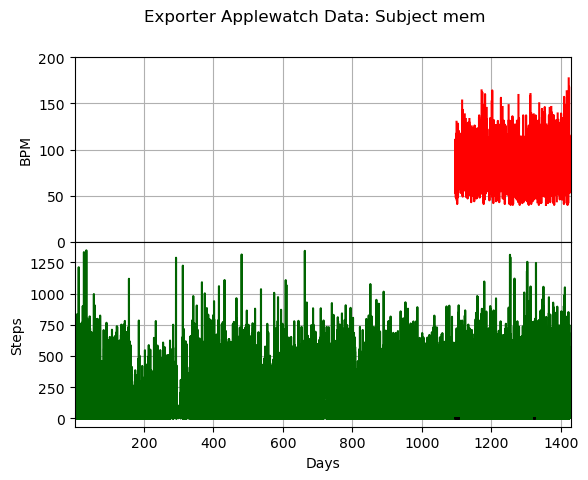

In [ ]:
#| export

def combine_wearable_streams(steps: pd.DataFrame, 
                                heartrate: pd.DataFrame,
                                wake: pd.DataFrame,
                                bin_minutes: int = 6,
                                subject_id: str="unknown-subject",
                                data_id: str ="Exporter",
                                sleep_trim: bool = False, # drop any entries without a sleep-wake entry
                                inner_join: bool = False # if true, only keep entries that have both heartrate and sleep data
                                ) -> WearableData:
    
    # Convert unix times to datetime
    steps['start'] = pd.to_datetime(steps.start, unit='s')
    steps['end'] = pd.to_datetime(steps.end, unit='s')
    wake['start'] = pd.to_datetime(wake.start, unit='s')
    wake['end'] = pd.to_datetime(wake.end, unit='s')
    heartrate['timestamp'] = pd.to_datetime(heartrate.timestamp, unit='s')
    
    # Resample the steps to the desired bin size
    s1 = steps.loc[:, ['start', 'steps']]
    s2 = steps.loc[:, ['end', 'steps']]
    s1.rename(columns={'start': 'timestamp'}, inplace=True)
    s2.rename(columns={'end': 'timestamp'}, inplace=True)
    steps = pd.concat([s1, s2])
    steps.set_index('timestamp', inplace=True)
    steps = steps.resample(str(int(bin_minutes)) +
                            'Min').agg({'steps': 'sum'})
    steps.reset_index(inplace=True)
    
    # Resample the heartrate data to the desired bin size
    heartrate.set_index('timestamp', inplace=True)
    heartrate = heartrate.resample(
        str(int(bin_minutes))+'Min').agg({'heartrate': 'max'})
    heartrate.reset_index(inplace=True)

    # Merge the steps and heartrate data and fill missing heartrate with zeros
    merge_method = 'inner' if inner_join else 'left'
    df = pd.merge(steps, heartrate, on='timestamp', how=merge_method)
    
    # Resample the wake data to the desired bin size
    s1 = wake.loc[:, ['start', 'wake']]
    s2 = wake.loc[:, ['end', 'wake']]
    s1.rename(columns={'start': 'timestamp'}, inplace=True)
    s2.rename(columns={'end': 'timestamp'}, inplace=True)
    wake = pd.concat([s1, s2])
    wake.set_index('timestamp', inplace=True)
    wake = wake.resample(str(int(bin_minutes)) +
                            'Min').agg({'wake': 'max'})
    wake.reset_index(inplace=True)
    
    merge_method = 'inner' if inner_join else 'left'
    df = pd.merge(df, wake, on='timestamp', how=merge_method)
    
    # Save the converted to a date time column as datetime
    df['datetime'] = df['timestamp']
    
    # Make the timestamp column actually be a unix timestamp
    df['timestamp'] = (
        df['datetime'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
    
    time_start = WearableData.utc_to_hrs(df.datetime.iloc[0])
    df['time_total'] = time_start + (df.timestamp-df.timestamp.iloc[0])/3600.0
    
    aw = WearableData(date_time=df.datetime.to_numpy(),
                    time_total=df.time_total.to_numpy(),
                    light_estimate=df.steps.to_numpy(), # Use steps as a light proxy
                    heartrate=df.heartrate.to_numpy(),
                    steps=df.steps.to_numpy(),
                    wake=df.wake.to_numpy(),
                    subject_id=subject_id,
                    data_id=data_id
                    )

    return aw
    

def read_standard_csv(directory_path: str, # path to the directory containing the csv files
                        bin_minutes: int = 6,
                        subject_id="unknown-subject",
                        data_id="Exporter",
                        sleep_trim: bool = False, # drop any entries without a sleep-wake entry
                        inner_join: bool = False # if true, only keep entries that have both heartrate and sleep data
                        ) -> WearableData:

    steps = pd.read_csv(directory_path+"/steps.csv", columns=['start', 'end', 'steps'])
    heartrate = pd.read_csv(directory_path+"/heartrate.csv", columns=['timestamp', 'heartrate'])
    wake = pd.read_csv(directory_path+"/sleep.csv", columns=['start', 'end', 'wake'])
    
    return combine_wearable_streams(steps, heartrate, wake, bin_minutes, subject_id, data_id, sleep_trim, inner_join)

        

def read_standard_json( filepath: str, # path to json file
                        bin_minutes: int = 6, # data will be binned to this resolution in minutes
                        subject_id: str ="unknown-subject", #subject id to be used
                        data_id: str = "Exporter", # name of the data source
                        gzip_opt: bool = False, # set to true if the file is gzipped, will be autodetected if extension is .gz
                        sleep_trim: bool = False, # drop any entries without a sleep-wake entry
                        inner_join: bool = False # if true, only keep entries that have both heartrate and sleep data
                        ) -> WearableData:
    gzip_opt = gzip_opt if gzip_opt else filepath.endswith(".gz")
    fileobj = gzip.open(filepath, 'r') if gzip_opt else open(filepath, 'r')
    rawJson = json.load(fileobj)
    validate(rawJson, wearable_schema)
    
    steps = pd.DataFrame(rawJson['steps'], columns=["start", "end", "steps"])
    # These could be empty
    wake = pd.DataFrame(rawJson['wake'], columns=["start", "end", "wake"]) 
    heartrate = pd.DataFrame(rawJson['heartrate'], columns=["timestamp", "heartrate"])
    
    return combine_wearable_streams(steps, heartrate, wake, bin_minutes, subject_id, data_id, sleep_trim, inner_join)
        
        


In [ ]:

# sample_data = read_standard_json(filepath="/Users/khannay/data/WearableData/LongTermUnlabeled/exporter/memAllData_converted.json", subject_id="mem")
# sample_data.plot_hr_steps()

<circadian.plots.Actogram>

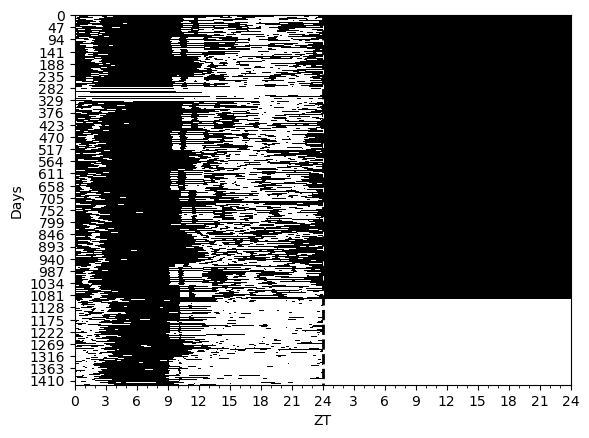

In [ ]:
# from circadian.plots import Actogram 

# Actogram(sample_data.time_total, sample_data.steps)

In [ ]:
#| export

@patch 
def plot_light_activity(self: WearableData, 
                        show=True, 
                        vlines=None, 
                        *args, **kwargs):

        fig = plt.figure()
        gs = fig.add_gridspec(2, hspace=0)
        ax = gs.subplots(sharex=True)
        fig.suptitle(
            f"{self.data_id} Subject {self.subject_id}")
        ax[0].plot(self.time_total / 24.0, np.log10(self.light_estimate+1.0), color='red')
        ax[1].plot(self.time_total / 24.0, self.activity, color='darkgreen')
        
        try:
            ax[1].plot(self.time_total / 24.0, self.wake *
                       np.median(self.steps), color='k')
        except:
            print(f"Error with wake plot with {self.subject_id}")

        if self.phase_measure_times is not None:
            [ax[0].axvline(x=_x / 24.0, ls='--', color='blue')
             for _x in self.phase_measure_times]
            [ax[1].axvline(x=_x / 24.0, ls='--', color='blue')
             for _x in self.phase_measure_times]

        if vlines is not None:
            [ax[0].axvline(x=_x / 24.0, ls='--', color='cyan')
             for _x in vlines]
            [ax[1].axvline(x=_x / 24.0, ls='--', color='cyan')
             for _x in vlines]

        ax[1].set_xlabel("Days")
        ax[0].set_ylabel("Lux (log 10)")
        ax[1].set_ylabel("Activity Counts")
        ax[0].grid()
        ax[1].grid()
        if show:
            plt.show()
        else:
            return ax


In [ ]:
#| export

@patch
def process_actiwatch(self: WearableData, 
                        filepath: str,
                        MIN_LIGHT_THRESHOLD=5000,
                        round_data=True,
                        bin_minutes=6,
                        dt_format: str = "%m/%d/%Y %I:%M:%S %p"
                        ) -> WearableData:
    """
        Takes in a csv with columns 
            Date : str 
            Time : str 
            White Light: float 
            Sleep/Wake: float 
            Activity: float
        returns a WearableData object
    """
    df = pd.read_csv(filepath)
    df['DateTime'] = df['Date']+" "+df['Time']
    df['DateTime'] = pd.to_datetime(
        df.DateTime, format=dt_format)

    df['UnixTime'] = (
        df['DateTime'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
    df['Lux'] = df['White Light']
    df.rename(columns={'Sleep/Wake': 'Wake'}, inplace=True)

    df['Lux'].fillna(0, inplace=True)
    df['LightSum'] = np.cumsum(df.Lux.values)
    df['LightSumReverse'] = np.sum(
        df.Lux.values) - np.cumsum(df.Lux.values) + 1.0

    df = df[(df.LightSum > MIN_LIGHT_THRESHOLD) & (
        df.LightSumReverse > MIN_LIGHT_THRESHOLD)]

    time_start = self.utc_to_hrs(df.DateTime.iloc[0])
    df2 = df[['UnixTime']].copy(deep=True)
    base_unix_time = df2['UnixTime'].iloc[0]
    df['TimeTotal'] = time_start + \
        (df2.loc[:, ['UnixTime']]-base_unix_time)/3600.0

    df = df[["DateTime", "TimeTotal", "UnixTime", "Activity", "Lux", "Wake"]]
    if round_data:
        df.set_index('DateTime', inplace=True)
        df = df.resample(str(int(bin_minutes))+'Min').agg({'TimeTotal': 'min',
                                                            'UnixTime': 'min',
                                                            'Activity': 'sum',
                                                            'Lux': 'median',
                                                            'Wake': 'max'})
        df.reset_index(inplace=True)

    # # Not sure why hchs needs this
    # df['TimeTotal'].interpolate(inplace=True)
    df.fillna(0, inplace=True)
    return WearableData(
        date_time=df.DateTime.values.to_numpy(),
        time_total=df.TimeTotal.values.to_numpy(),
        light_estimate=df.Lux.values.to_numpy(),
        activity=df.Activity.values.to_numpy(),
    )


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()